<a href="https://www.kaggle.com/code/chakramlops/house-rent-regression-analysis?scriptVersionId=189275719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict House Rent using Multiple Linear Regression 
***What we learn from this notebook***

1. **Data Collection and Preparation**
   * Gather Data
   * Remove **TOTALLY** unrelated columns from dataset
   * Encode cateorical features
   * Handle too many unique values in categorical features (Cordinality)
   * Missing value handling 
  
  
2. **Exploratory Data Analysis (EDA)**
   * Remove outliers
   * Understand data distribution (mean, median, mode, standard deviation).
   * Check for correlations & covariance between features.
   
   
3. **Feature Selection & Engineering**
   *  Select relevant features based on correlation, mutual information, feature importance, Lasso, RFE, R-squared, p-values, and VIF.
   * Create new features if necessary.
   
   
4. **Check for Assumptions of Linear Regression**
   * **Linearity**: The relationship between predictors and the target should be linear.
   * **Independence**: Observations should be independent of each other,
   * **Homoscedasticity**: Constant variance of the residuals
   * **Normality of Residuals**: Residuals should be normally distributed.
   * **No Multicollinearity**: Predictors should not be highly correlated with each other.
   
   
5. **Model Training**
   * Split data into training and testing sets.
   * Train the multiple linear regression model.
   
   
6. **Model Evaluation**
   * Evaluate the model using metrics like R-squared, adjusted R-squared, Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).
   * Check residual plots to ensure assumptions are met.
   
   
7. **Predict Rental based on new model created**
 

In [1]:
#Gather Data and load
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("\nDataSet Location: ", os.path.join(dirname, filename))
        dataset_path = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


DataSet Location:  /kaggle/input/house-rent-prediction/House_Rent_Dataset.csv


In [2]:
#Create dataframe 
df = pd.read_csv(dataset_path)
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
#Check number of rows and columns in the DataFrame
df.shape

(4746, 12)

In [4]:
#Check data types of each featues in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


# Cordinality Check

In [5]:
#Check for cardinolity of features in the dataframe

object_columns = df.select_dtypes(include=['object']).columns 
for col in object_columns:
    print (col,':', df[col].nunique())

Posted On : 81
Floor : 480
Area Type : 3
Area Locality : 2235
City : 6
Furnishing Status : 3
Tenant Preferred : 3
Point of Contact : 3


We can see ***Posted On***, ***Floor*** and ***Area Locality*** features have many distict values. Too many distinct values will not help in 
prediction

Lets inspect each of these features and extract/convert meaning full data

In [6]:
#Check the missing value in large unique object columns
large_unique_columns = ['Posted On','Floor','Area Locality']
for col in large_unique_columns:
    print (col,': ',df[col].isnull().sum())

Posted On :  0
Floor :  0
Area Locality :  0


There are no null values in any of these large unique values features 

# Feature 'Floor' Handling 

In [7]:
#The Floor feature can be divide into 2 features so that rental for floor out of total floor in the apartment would provide insight
# Regular expression to extract the current floor and total number of floors
pattern = r'(?P<CurrentFloor>\w+)\s*out\s*of\s*(?P<TotalFloors>\d+)'

# Extract the values into new columns
df[['CurrentFloor', 'TotalFloors']] = df['Floor'].str.extract(pattern)

# Replace non-numeric floor labels with specific values
floor_replacements = {
    'Ground': 0,
    'Basement': -1  # Assuming 'Basement' should be treated as floor -1
}

df['CurrentFloor'] = df['CurrentFloor'].replace(floor_replacements)
# Convert columns to appropriate data types
df['CurrentFloor'] = pd.to_numeric(df['CurrentFloor'], errors='coerce')
df['TotalFloors'] = pd.to_numeric(df['TotalFloors'], errors='coerce')
df = df.drop(columns=['Floor'])

Though the Floor column was having 480 unique values but not CurrentFloor and TotalFloors features have ~60 unique values. Though these new features having ~60 unique values, these features may have more influence in the predicting the rental 

The new features of Floor is already in numeric and its suitable for ML models. 

In [8]:
# Create new features
df['FloorRatio'] = df['CurrentFloor'] / df['TotalFloors']
df['IsTopFloor'] = (df['CurrentFloor'] == df['TotalFloors']).astype(int)

# Feature Engineering with Transformed Variables
Creating new features based on the transformed variables "Current Floor" and "Total Floor" can provide additional insights and improve model performance. Here are a few examples of how to create these new features:

  1. **Ratio of Current Floor to Total Floors**: This feature captures the relative position of the current floor within the building.
     * **Purpose**: This feature captures the relative position of the current floor within the building, which might influence the price. For example, higher floors might have better views and thus higher prices.
     * **Interpretation**: A value closer to 1 indicates a higher floor relative to the building's height.
     
     
  2. **Is Top Floor**: This binary feature indicates whether the current floor is the top floor in the building.
     * **Purpose**: This binary feature indicates whether the current floor is the top floor. The top floor might have specific characteristics that influence the price, such as better views or more privacy.
     * **Interpretation**: A value of 1 indicates that the current floor is the top floor, and 0 indicates it is not.

# Feature 'Area Locality' Handling 

In [9]:
print ("Total Unique value in Area Locality: ", df['Area Locality'].nunique())
df['Area Locality'].value_counts()

Total Unique value in Area Locality:  2235


Area Locality
Bandra West                                37
Gachibowli                                 29
Electronic City                            24
Velachery                                  22
Miyapur, NH 9                              22
                                           ..
Kengeri Upanagara                           1
Ittamadu, Banashankari, Outer Ring Road     1
Rmv Extension, Armane Nagar                 1
snv la                                      1
Manikonda, Hyderabad                        1
Name: count, Length: 2235, dtype: int64

Though there are ~50% of unique values from total and yet having this data is crucial in predicting the rent of a house because, In bangalore, basedon the IT companies, rental will have huge impact 


In [10]:
# Count occurrences of each area locality within each city
locality_counts = df.groupby('City')['Area Locality'].value_counts().reset_index(name='Count')

# Identify top 20 area localities for each city
top_10_localities = locality_counts.groupby('City').apply(lambda x: x.nlargest(20, 'Count')).reset_index(drop=True)

# Create a set of top 20 localities for each city
top_10_set = top_10_localities.groupby('City')['Area Locality'].apply(set).to_dict()

# Function to label localities
def label_locality(row):
    city, locality = row['City'], row['Area Locality']
    if locality in top_10_set[city]:
        return locality
    else:
        return 'Others'

# Apply the function to label localities
df['Area Locality Labeled'] = df.apply(label_locality, axis=1)

df.head()
#df = df.drop(columns=['Area Locality'])

/tmp/ipykernel_18/1328811016.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_localities = locality_counts.groupby('City').apply(lambda x: x.nlargest(20, 'Count')).reset_index(drop=True)


,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0.0,2.0,0.000000,0,Others
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Others
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1.0,2.0,0.500000,0,Others
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1.0,2.0,0.500000,0,Others


Area of a City influences the renatal in Cities for various reasons like IT companies, Garment companies, schools/colleges, high raised apartments and other fesilities around the city. So, we have decided to take top 25 cities as labeled as seperate and all other put it a **OTHERS** category  

# Feature 'Posted On' Handling
Calculating or dividing when it was posted gives more insights to see which period if posting will have influence of rental houses.

**Example**: Year 2008 was recession, 2020 COVID and so on


In [11]:
df['Year'] = pd.to_datetime(df['Posted On']).dt.year
print ("Year wise count: ", df['Year'].value_counts())
df.head()

Year wise count:  Year
2022    4746
Name: count, dtype: int64


,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Year
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0.0,2.0,0.000000,0,Others,2022
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Others,2022
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2,2022
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1.0,2.0,0.500000,0,Others,2022
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1.0,2.0,0.500000,0,Others,2022


The Posted On was only for the year 2022 and it may not be giving good result for our ML prediction 

In [12]:
df = df.drop(columns=['Posted On','Year','Area Locality'])
#Check for cardinolity of features in the dataframe

object_columns = df.select_dtypes(include=['object']).columns 
for col in object_columns:
    print (col,':', df[col].nunique())

Area Type : 3
City : 6
Furnishing Status : 3
Tenant Preferred : 3
Point of Contact : 3
Area Locality Labeled : 121


# Start Encoding of Categorical features for ML 
Inspect each categorical features in the dataset and use appropriate encoding method to convert

In [13]:
object_columns = df.select_dtypes (include=['object']).columns
for col in object_columns:
    print (col ,': ',df[col].nunique())

Area Type :  3
City :  6
Furnishing Status :  3
Tenant Preferred :  3
Point of Contact :  3
Area Locality Labeled :  121


In [14]:
# The feature Area Type doesn't seem adding any value to the dataset in predicting the rental 
df = df.drop(columns=['Area Type'])

In [15]:
df.head()

,BHK,Rent,Size,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled
0,2,10000,1100,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0.0,2.0,0.000000,0,Others
1,2,20000,800,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Others
2,2,17000,1000,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2
3,2,10000,800,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1.0,2.0,0.500000,0,Others
4,2,7500,850,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1.0,2.0,0.500000,0,Others


In [16]:
df['Tenant Preferred'].value_counts()

Tenant Preferred
Bachelors/Family    3444
Bachelors            830
Family               472
Name: count, dtype: int64

# Encoding 'Tenant Preferred' Feature 
This feature contains 3 unique values and its nominal values. So, I choose One-Hot Encoding method 


In [17]:
df.head()

,BHK,Rent,Size,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled
0,2,10000,1100,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0.0,2.0,0.000000,0,Others
1,2,20000,800,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Others
2,2,17000,1000,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2
3,2,10000,800,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1.0,2.0,0.500000,0,Others
4,2,7500,850,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1.0,2.0,0.500000,0,Others


In [18]:
# Apply one-hot encoding
df = pd.get_dummies(df, columns=['Tenant Preferred'])

# Identify boolean columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print (boolean_columns)

# Convert boolean columns to integers
df[boolean_columns] = df[boolean_columns].astype(int)

df.head()

Index(['Tenant Preferred_Bachelors', 'Tenant Preferred_Bachelors/Family',
       'Tenant Preferred_Family'],
      dtype='object')


,BHK,Rent,Size,City,Furnishing Status,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family
0,2,10000,1100,Kolkata,Unfurnished,2,Contact Owner,0.0,2.0,0.000000,0,Others,0,1,0
1,2,20000,800,Kolkata,Semi-Furnished,1,Contact Owner,1.0,3.0,0.333333,0,Others,0,1,0
2,2,17000,1000,Kolkata,Semi-Furnished,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2,0,1,0
3,2,10000,800,Kolkata,Unfurnished,1,Contact Owner,1.0,2.0,0.500000,0,Others,0,1,0
4,2,7500,850,Kolkata,Unfurnished,1,Contact Owner,1.0,2.0,0.500000,0,Others,1,0,0


# Encoding 'Furnishing Status' Feature 
This feature contains 3 unique values in the variable but furnishing have some kind of order as well in the rental and hence decided to use **Binary Encoding**


In [19]:
import category_encoders as ce
# Apply Binary Encoding
binary_encoder = ce.BinaryEncoder(cols=['Furnishing Status'])
df = binary_encoder.fit_transform(df)
df.head()

,BHK,Rent,Size,City,Furnishing Status_0,Furnishing Status_1,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family
0,2,10000,1100,Kolkata,0,1,2,Contact Owner,0.0,2.0,0.000000,0,Others,0,1,0
1,2,20000,800,Kolkata,1,0,1,Contact Owner,1.0,3.0,0.333333,0,Others,0,1,0
2,2,17000,1000,Kolkata,1,0,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2,0,1,0
3,2,10000,800,Kolkata,0,1,1,Contact Owner,1.0,2.0,0.500000,0,Others,0,1,0
4,2,7500,850,Kolkata,0,1,1,Contact Owner,1.0,2.0,0.500000,0,Others,1,0,0


# Encoding 'City' Feature
This feature contains 5 unique values in the variable but furnishing have some kind of order as well in the rental and hence decided to use **Binary Encoding**


In [20]:
# Apply Binary Encoding
binary_encoder = ce.BinaryEncoder(cols=['City'])
df = binary_encoder.fit_transform(df)
df.head()

,BHK,Rent,Size,City_0,City_1,City_2,Furnishing Status_0,Furnishing Status_1,Bathroom,Point of Contact,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family
0,2,10000,1100,0,0,1,0,1,2,Contact Owner,0.0,2.0,0.000000,0,Others,0,1,0
1,2,20000,800,0,0,1,1,0,1,Contact Owner,1.0,3.0,0.333333,0,Others,0,1,0
2,2,17000,1000,0,0,1,1,0,1,Contact Owner,1.0,3.0,0.333333,0,Salt Lake City Sector 2,0,1,0
3,2,10000,800,0,0,1,0,1,1,Contact Owner,1.0,2.0,0.500000,0,Others,0,1,0
4,2,7500,850,0,0,1,0,1,1,Contact Owner,1.0,2.0,0.500000,0,Others,1,0,0


# Encoding 'Point of Contact' Feature 
This feature contains 3 unique values and its nominal values. So, I choose One-Hot Encoding method 


In [21]:
# Apply one-hot encoding
df = pd.get_dummies(df, columns=['Point of Contact'])

# Identify boolean columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print (boolean_columns)

# Convert boolean columns to integers
df[boolean_columns] = df[boolean_columns].astype(int)

df.head()

Index(['Point of Contact_Contact Agent', 'Point of Contact_Contact Builder',
       'Point of Contact_Contact Owner'],
      dtype='object')


,BHK,Rent,Size,City_0,City_1,City_2,Furnishing Status_0,Furnishing Status_1,Bathroom,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,10000,1100,0,0,1,0,1,2,0.0,2.0,0.000000,0,Others,0,1,0,0,0,1
1,2,20000,800,0,0,1,1,0,1,1.0,3.0,0.333333,0,Others,0,1,0,0,0,1
2,2,17000,1000,0,0,1,1,0,1,1.0,3.0,0.333333,0,Salt Lake City Sector 2,0,1,0,0,0,1
3,2,10000,800,0,0,1,0,1,1,1.0,2.0,0.500000,0,Others,0,1,0,0,0,1
4,2,7500,850,0,0,1,0,1,1,1.0,2.0,0.500000,0,Others,1,0,0,0,0,1


# Handling Missing Values
Check the Skewness of the Current, Total and Ration, correlation with rent feature and decide which method to use for handling missing values

In [22]:
#List of missing value count for all features excluding categorical features
object_columns = df.select_dtypes (exclude =['object']).columns
for col in object_columns:
    print (col ,': ',df[col].isnull().sum())

BHK :  0
Rent :  0
Size :  0
City_0 :  0
City_1 :  0
City_2 :  0
Furnishing Status_0 :  0
Furnishing Status_1 :  0
Bathroom :  0
CurrentFloor :  4
TotalFloors :  4
FloorRatio :  4
IsTopFloor :  0
Tenant Preferred_Bachelors :  0
Tenant Preferred_Bachelors/Family :  0
Tenant Preferred_Family :  0
Point of Contact_Contact Agent :  0
Point of Contact_Contact Builder :  0
Point of Contact_Contact Owner :  0


In [23]:
#See the missing actual values
df[df.isnull().any(axis=1)]

,BHK,Rent,Size,City_0,City_1,City_2,Furnishing Status_0,Furnishing Status_1,Bathroom,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
2553,2,20000,400,1,0,0,0,1,1,NaN,NaN,NaN,0,Others,0,1,0,0,0,1
2883,1,18000,450,1,0,0,1,1,1,NaN,NaN,NaN,0,Others,0,1,0,0,0,1
4490,3,15000,900,1,1,0,1,0,3,NaN,NaN,NaN,0,Others,0,1,0,0,0,1
4560,3,15000,1270,1,1,0,1,1,2,NaN,NaN,NaN,0,Others,0,0,1,0,0,1


In [24]:
print ("Mean of Current Floor : ", df['CurrentFloor'].mean())
print ("Median of current Floor : ", df['CurrentFloor'].median())
print ("SKEW of current Floor : ", df['CurrentFloor'].skew())

print ("Mean of Total Floor : ", df['TotalFloors'].mean())
print ("Median of Total Floor : ", df['TotalFloors'].median())
print ("SKEW of Total Floor : ", df['TotalFloors'].skew())

print ("Mean of Ratio Floor : ", df['FloorRatio'].mean())
print ("Median of Ratio Floor : ", df['FloorRatio'].median())
print ("SKEW of Ratio Floor : ", df['FloorRatio'].skew())

correlation_rent_cfloor = df['Rent'].corr(df['CurrentFloor'])
print ("Corr Rent Vs CurrentFloor : ", correlation_rent_cfloor)

correlation_rent_cfloor = df['Rent'].corr(df['TotalFloors'])
print ("Corr Rent Vs TotalFloor : ", correlation_rent_cfloor)

correlation_rent_cfloor = df['Rent'].corr(df['FloorRatio'])
print ("Corr Rent Vs TotalFloor : ", correlation_rent_cfloor)

Mean of Current Floor :  3.4403205398566006
Median of current Floor :  2.0
SKEW of current Floor :  4.660440639075578
Mean of Total Floor :  6.9734289329396875
Median of Total Floor :  4.0
SKEW of Total Floor :  3.705418596928207
Mean of Ratio Floor :  0.45610908906474584
Median of Ratio Floor :  0.5
SKEW of Ratio Floor :  -0.02442052085023481
Corr Rent Vs CurrentFloor :  0.3263658008506916
Corr Rent Vs TotalFloor :  0.35221294253189933
Corr Rent Vs TotalFloor :  0.07572769785315452


**SKEW** is on right side and correlation is also not that great, so its good to use median imputation for this  

In [25]:
#Apply Mean Imputatio
from sklearn.impute import SimpleImputer

# Median Imputation for Age and Income columns
median_imputer = SimpleImputer(strategy='median')

df['CurrentFloor'] = median_imputer.fit_transform(df[['CurrentFloor']])
#df['Rent'] = median_imputer.fit_transform(df[['Rent']])
df['TotalFloors'] = median_imputer.fit_transform(df[['TotalFloors']])
df['FloorRatio'] = median_imputer.fit_transform(df[['FloorRatio']])
df.head()


,BHK,Rent,Size,City_0,City_1,City_2,Furnishing Status_0,Furnishing Status_1,Bathroom,CurrentFloor,TotalFloors,FloorRatio,IsTopFloor,Area Locality Labeled,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,10000,1100,0,0,1,0,1,2,0.0,2.0,0.000000,0,Others,0,1,0,0,0,1
1,2,20000,800,0,0,1,1,0,1,1.0,3.0,0.333333,0,Others,0,1,0,0,0,1
2,2,17000,1000,0,0,1,1,0,1,1.0,3.0,0.333333,0,Salt Lake City Sector 2,0,1,0,0,0,1
3,2,10000,800,0,0,1,0,1,1,1.0,2.0,0.500000,0,Others,0,1,0,0,0,1
4,2,7500,850,0,0,1,0,1,1,1.0,2.0,0.500000,0,Others,1,0,0,0,0,1


# Remove Outliers 
Check if there are outliers in each of the interested features and then take decision to remove outliers with appropriate methods 

**Shapiro-Wilk Test**: The Shapiro-Wilk test is a statistical test that is used to determine whether a sample comes from a normally distributed population. It is one of the most powerful tests for normality, particularly for small sample sizes.

**Null Hypothesis (H0) and Alternative Hypothesis (H1)**

  * **Null Hypothesis (H0)**: The data is normally distributed.
  * **Alternative Hypothesis (H1)**: The data is not normally distributed.
  
  
**Test Statistic and P-value**
  * **Test Statistic (W)**: The test statistic W measures how well the data fits a normal distribution. It ranges from 0 to 1, with 1 indicating perfect normality.
  * **P-value**: The p-value indicates the probability of obtaining the observed results, or more extreme results, if the null hypothesis is true. A low p-value (typically ≤ 0.05) indicates that the null hypothesis can be rejected.
  
  
**Interpretation**
  * **If p-value > 0.05**: Fail to reject the null hypothesis (H0). There is no significant evidence to say that the data is not normally distributed.
  * **If p-value ≤ 0.05**: Reject the null hypothesis (H0). There is significant evidence to say that the data is not normally distributed.


In [26]:
import scipy.stats as stats

columns_interested = ['BHK','Rent','Size','Bathroom']

for col in columns_interested:
    # Perform Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(df[col])
    print(f'Shapiro-Wilk Test: Statistics={shapiro_stat}, p={shapiro_p}')

    # Interpretation
    alpha = 0.05
    if shapiro_p > alpha:
        print("Fail to reject the null hypothesis: The data is normally distributed.",col)
    else:
        print("Reject the null hypothesis: The data is not normally distributed.",col)


Shapiro-Wilk Test: Statistics=0.8496379852294922, p=0.0
Reject the null hypothesis: The data is not normally distributed. BHK
Shapiro-Wilk Test: Statistics=0.29155057668685913, p=0.0
Reject the null hypothesis: The data is not normally distributed. Rent
Shapiro-Wilk Test: Statistics=0.8436328172683716, p=0.0
Reject the null hypothesis: The data is not normally distributed. Size
Shapiro-Wilk Test: Statistics=0.8088299632072449, p=0.0
Reject the null hypothesis: The data is not normally distributed. Bathroom


The above results suggest that there is no normal distribution. However, lets apply IQR method and see hot good it may fit

In [27]:
columns_interested = ['BHK','Bathroom','Rent']
for col in columns_interested:
    print ("IQR for the Column: ", col)
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.20)
    Q3 = df[col].quantile(0.80)
    IQR = Q3 - Q1

    print(f"First Quartile (Q1): {Q1}")
    print(f"Third Quartile (Q3): {Q3}")
    print(f"Interquartile Range (IQR): {IQR}")

    #Identify Outliers
    # Calculate bounds for outliers
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    print ("lower_bound: ",lower_bound)
    print ("upper_bound: ",upper_bound)
    print ("IQR: ",IQR)

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    #print ("outliers: ", outliers)

    print("Outliers identified by IQR method:")
    print(outliers[col].value_counts())
    # Remove outliers
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    df[col].value_counts().sum()
    
    print (" ")


IQR for the Column:  BHK
First Quartile (Q1): 1.0
Third Quartile (Q3): 3.0
Interquartile Range (IQR): 2.0
lower_bound:  -2.0
upper_bound:  6.0
IQR:  2.0
Outliers identified by IQR method:
Series([], Name: count, dtype: int64)
 
IQR for the Column:  Bathroom
First Quartile (Q1): 1.0
Third Quartile (Q3): 3.0
Interquartile Range (IQR): 2.0
lower_bound:  -2.0
upper_bound:  6.0
IQR:  2.0
Outliers identified by IQR method:
Bathroom
7     3
10    1
Name: count, dtype: int64
 
IQR for the Column:  Rent
First Quartile (Q1): 9000.0
Third Quartile (Q3): 40000.0
Interquartile Range (IQR): 31000.0
lower_bound:  -37500.0
upper_bound:  86500.0
IQR:  31000.0
Outliers identified by IQR method:
Rent
100000     39
150000     37
130000     27
90000      24
140000     21
180000     19
120000     18
95000      16
110000     15
200000     14
250000     14
300000     12
190000     11
160000     10
280000      8
350000      8
170000      7
400000      7
230000      6
260000      5
600000      4
330000      4
2

# Understand Data Distribution 
**Mean, Median, mode, Skewness and Kurtosis**

In [28]:
columns_interested = ['BHK','Rent','Size','Bathroom']
for col in columns_interested:
    print ("Mean of ",col, ': ', df[col].mean())
    print ("Median of ",col, ': ', df[col].median())
    print ("STD Deviation of ",col, ': ', df[col].std())
    print ("Skew of ",col, ': ', df[col].skew())
    print ("Kurtosis of ",col, ': ', df[col].kurtosis())
    print (" ")

Mean of  BHK :  1.9833180987202925
Median of  BHK :  2.0
STD Deviation of  BHK :  0.7528661002111986
Skew of  BHK :  0.46788870394564086
Kurtosis of  BHK :  0.48825737947536707
 
Mean of  Rent :  21262.184643510056
Median of  Rent :  15000.0
STD Deviation of  Rent :  17181.463828212796
Skew of  Rent :  1.6953623077072186
Kurtosis of  Rent :  2.4796182645410645
 
Mean of  Size :  886.4017367458866
Median of  Size :  800.0
STD Deviation of  Size :  504.04069897959647
Skew of  Size :  1.3376299339468245
Kurtosis of  Size :  3.7242209890611364
 
Mean of  Bathroom :  1.8340950639853748
Median of  Bathroom :  2.0
STD Deviation of  Bathroom :  0.723413024323431
Skew of  Bathroom :  0.6931456324290698
Kurtosis of  Bathroom :  1.0847992358079348
 


**BHK**:
  * The mean (2.082) and median (2.0) are very close, suggesting that the distribution is fairly symmetric.
  * Skewness of 0.569 suggests that the distribution is moderately skewed to the right. A skewness value between -0.5 and 0.5 indicates a fairly symmetrical distribution, while values between 0.5 and 1 (or -0.5 and -1) indicate moderate skewness. Therefore, 0.5992 indicates moderate right skewness.
  * Kurtosis of 0.462 indicates a distribution that is relatively flat compared to a normal distribution (platykurtic). This means there are fewer extreme outliers in the tails of the distribution compared to a normal distribution.
  
**Apply Log Transformation for BHK**

**###################################################################################################**

**RENT**

  * The mean (34929.13) is significantly higher than the median (16000.0), suggesting a right-skewed distribution.
  * A skewness of 21.446 indicates a highly right-skewed distribution. This extreme skewness suggests the presence of very high rent values (outliers).
  * A kurtosis of 842.863 indicates a distribution with extremely heavy tails (leptokurtic). This means there are many outliers far from the mean.

**Apply Log Transformation for RENT**

**###################################################################################################**

**Size**

  * The mean (964.47) is higher than the median (850.0), indicating a right-skewed distribution.
  * A skewness of 2.096 indicates a moderately to highly right-skewed distribution. This suggests the presence of higher values (outliers) pulling the mean to the right
  * A kurtosis of 8.500 indicates a distribution with very heavy tails (leptokurtic). This means there are many outliers far from the mean.
  
**Apply Log Transformation for RENT**

**###################################################################################################**

**Bathroom**

  * The mean (1.961) and median (2.0) are very close, suggesting that the distribution is fairly symmetric around the central tendency, although slightly right-skewed.
  * A skewness of 1.074 indicates moderate right skewness. This suggests the presence of some higher values (outliers) pulling the mean to the right.
  * A kurtosis of 1.887 indicates a distribution with somewhat heavy tails (leptokurtic), meaning there are some outliers, but it's not extremely peaked.
  
  
**No log transformation needed for this**



# Apply Transformation for BHK, Rent and Bathrooms

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


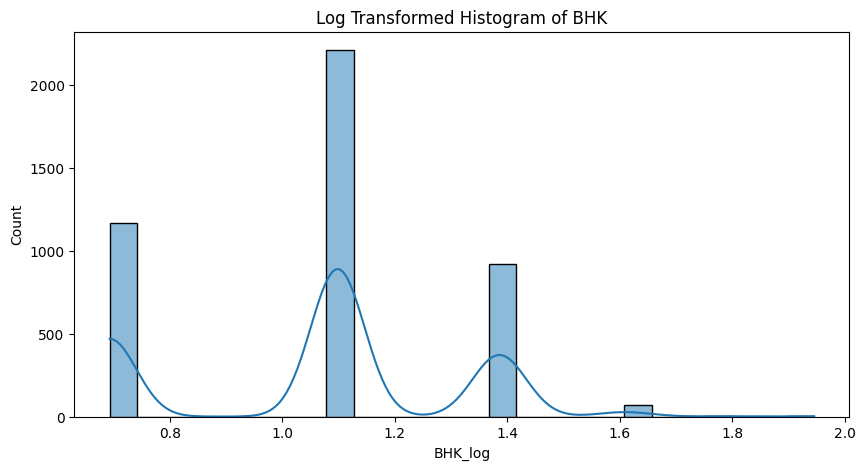

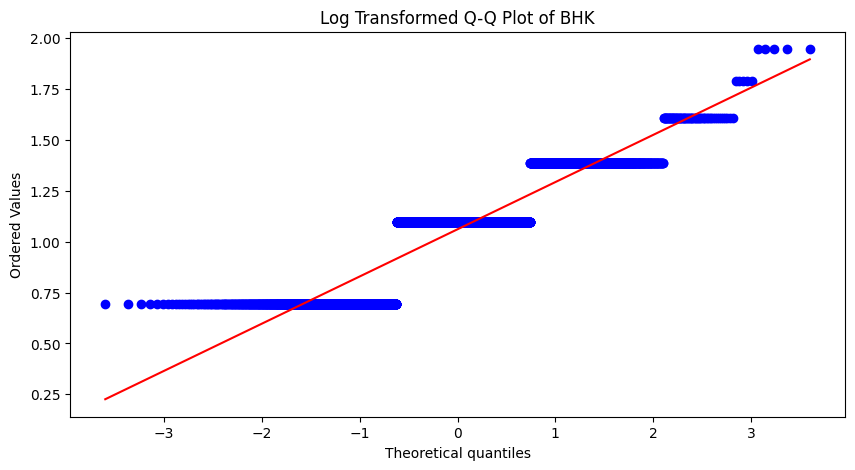

In [29]:
# Apply Log Transformation
import seaborn as sns 
import matplotlib.pyplot as plt
df['BHK_log'] = np.log1p(df['BHK'])

# Visualize Transformed Data
plt.figure(figsize=(10, 5))
sns.histplot(df['BHK_log'], kde=True)
plt.title('Log Transformed Histogram of BHK')
plt.show()

plt.figure(figsize=(10, 5))
stats.probplot(df['BHK_log'], dist="norm", plot=plt)
plt.title('Log Transformed Q-Q Plot of BHK')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


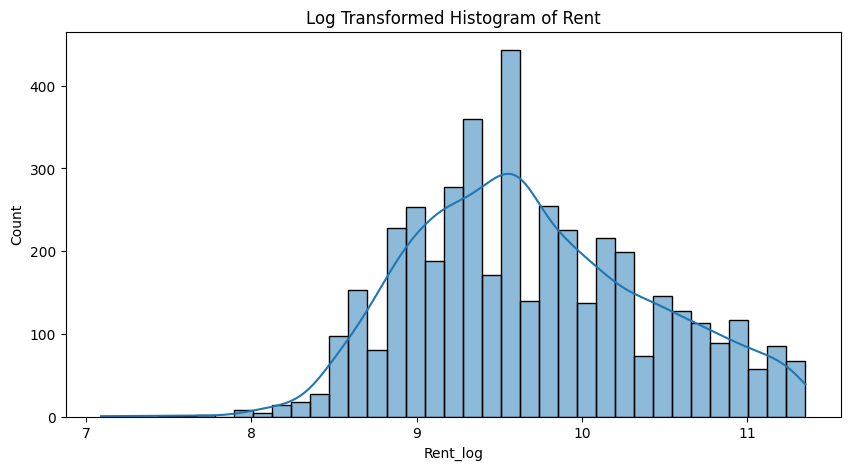

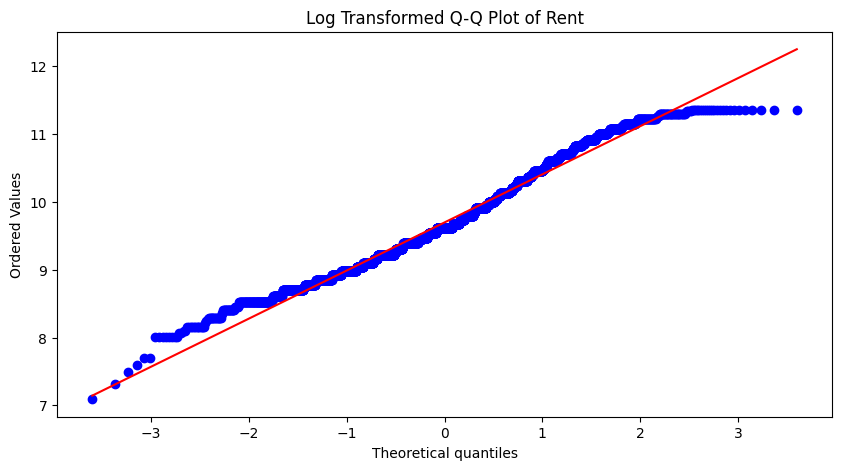

In [30]:
# Apply Log Transformation
df['Rent_log'] = np.log1p(df['Rent'])

# Visualize Transformed Data
plt.figure(figsize=(10, 5))
sns.histplot(df['Rent_log'], kde=True)
plt.title('Log Transformed Histogram of Rent')
plt.show()

plt.figure(figsize=(10, 5))
stats.probplot(df['Rent_log'], dist="norm", plot=plt)
plt.title('Log Transformed Q-Q Plot of Rent')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


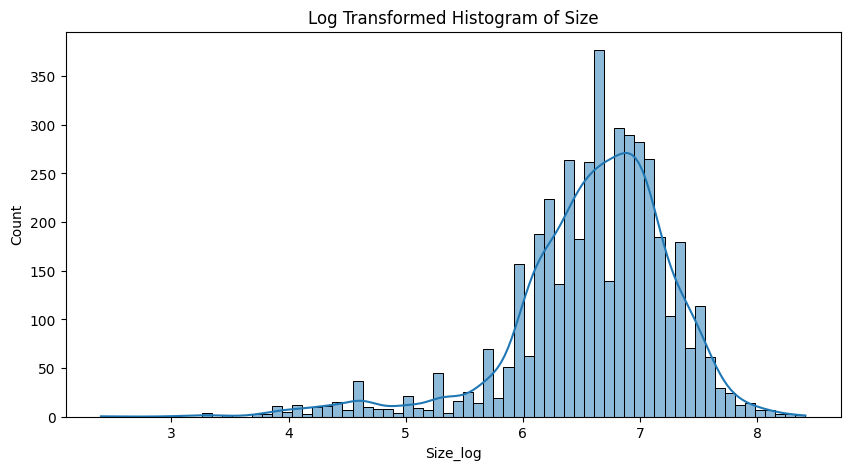

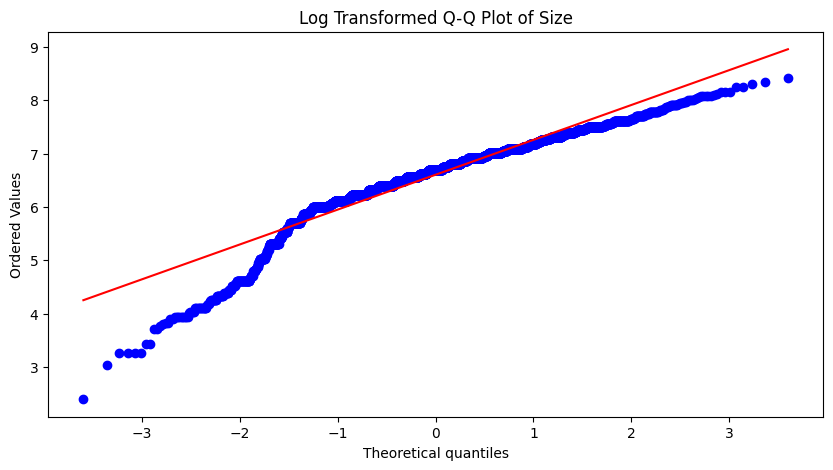

In [31]:
# Apply Log Transformation
df['Size_log'] = np.log1p(df['Size'])

# Visualize Transformed Data
plt.figure(figsize=(10, 5))
sns.histplot(df['Size_log'], kde=True)
plt.title('Log Transformed Histogram of Size')
plt.show()

plt.figure(figsize=(10, 5))
stats.probplot(df['Size_log'], dist="norm", plot=plt)
plt.title('Log Transformed Q-Q Plot of Size')
plt.show()


# Correlation and Coveriance Check

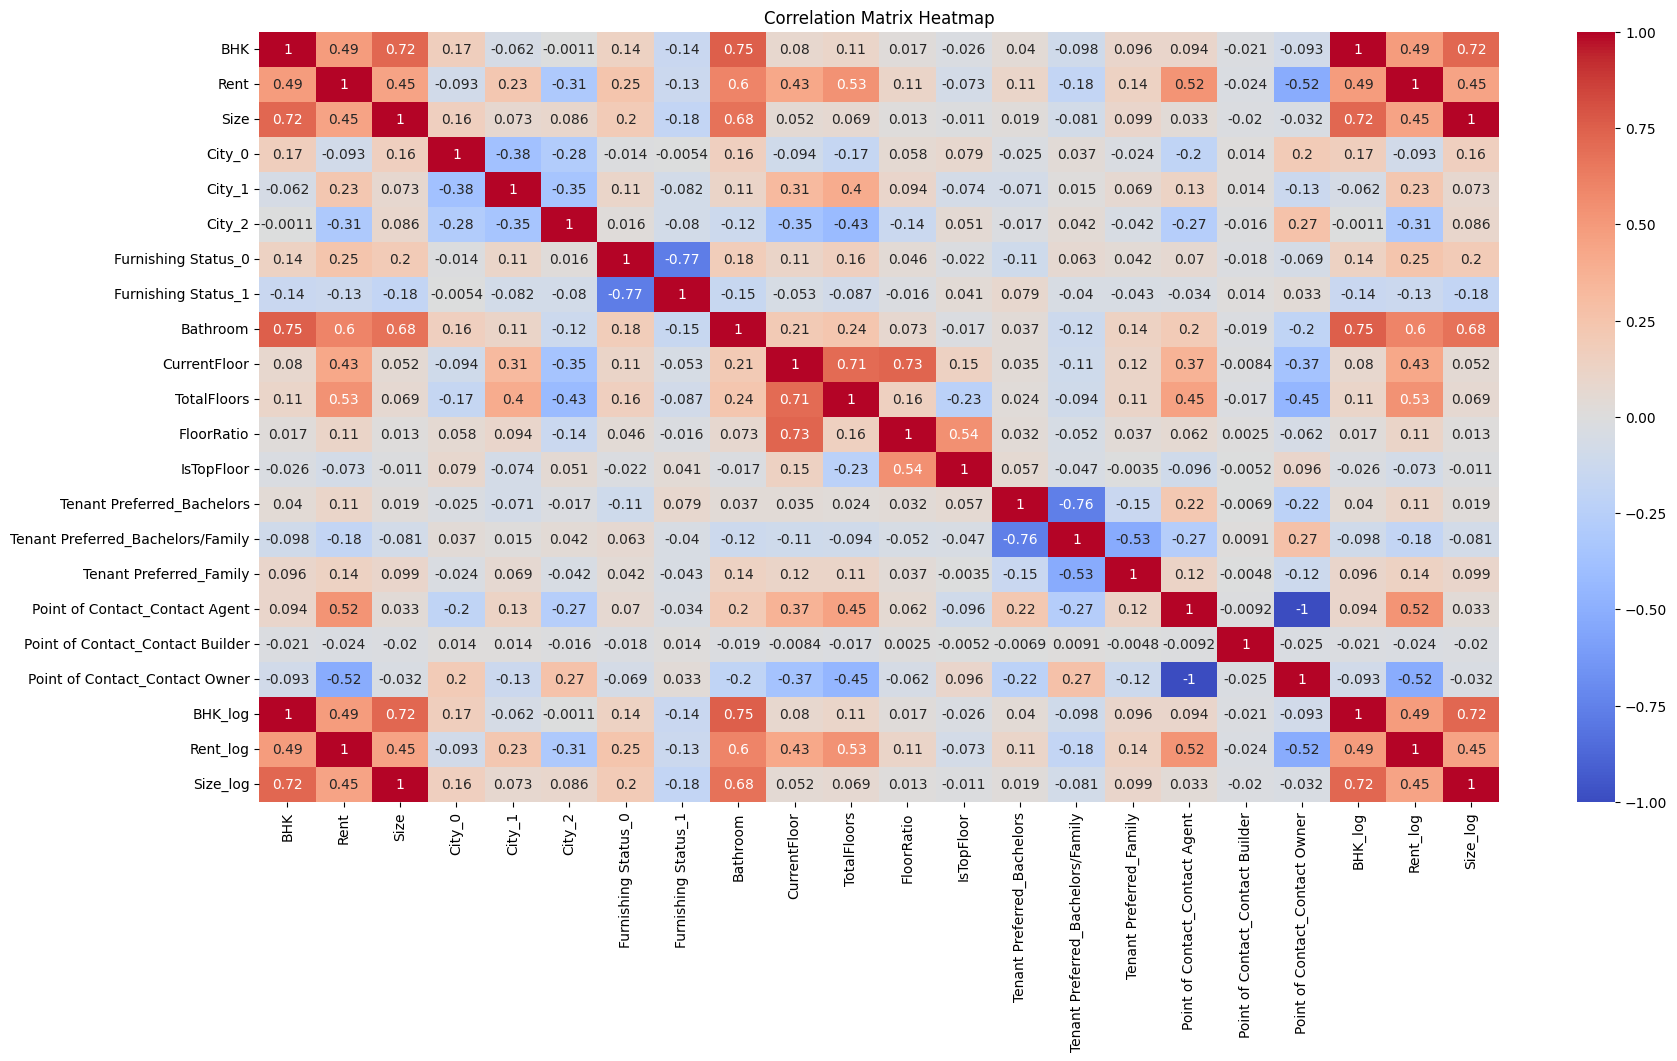

In [32]:
columns = df.select_dtypes(exclude=['object']).columns
# Calculate Pearson correlation
correlation_matrix = df[columns].corr(method='spearman')

# Visualize the Correlation Matrix using a Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

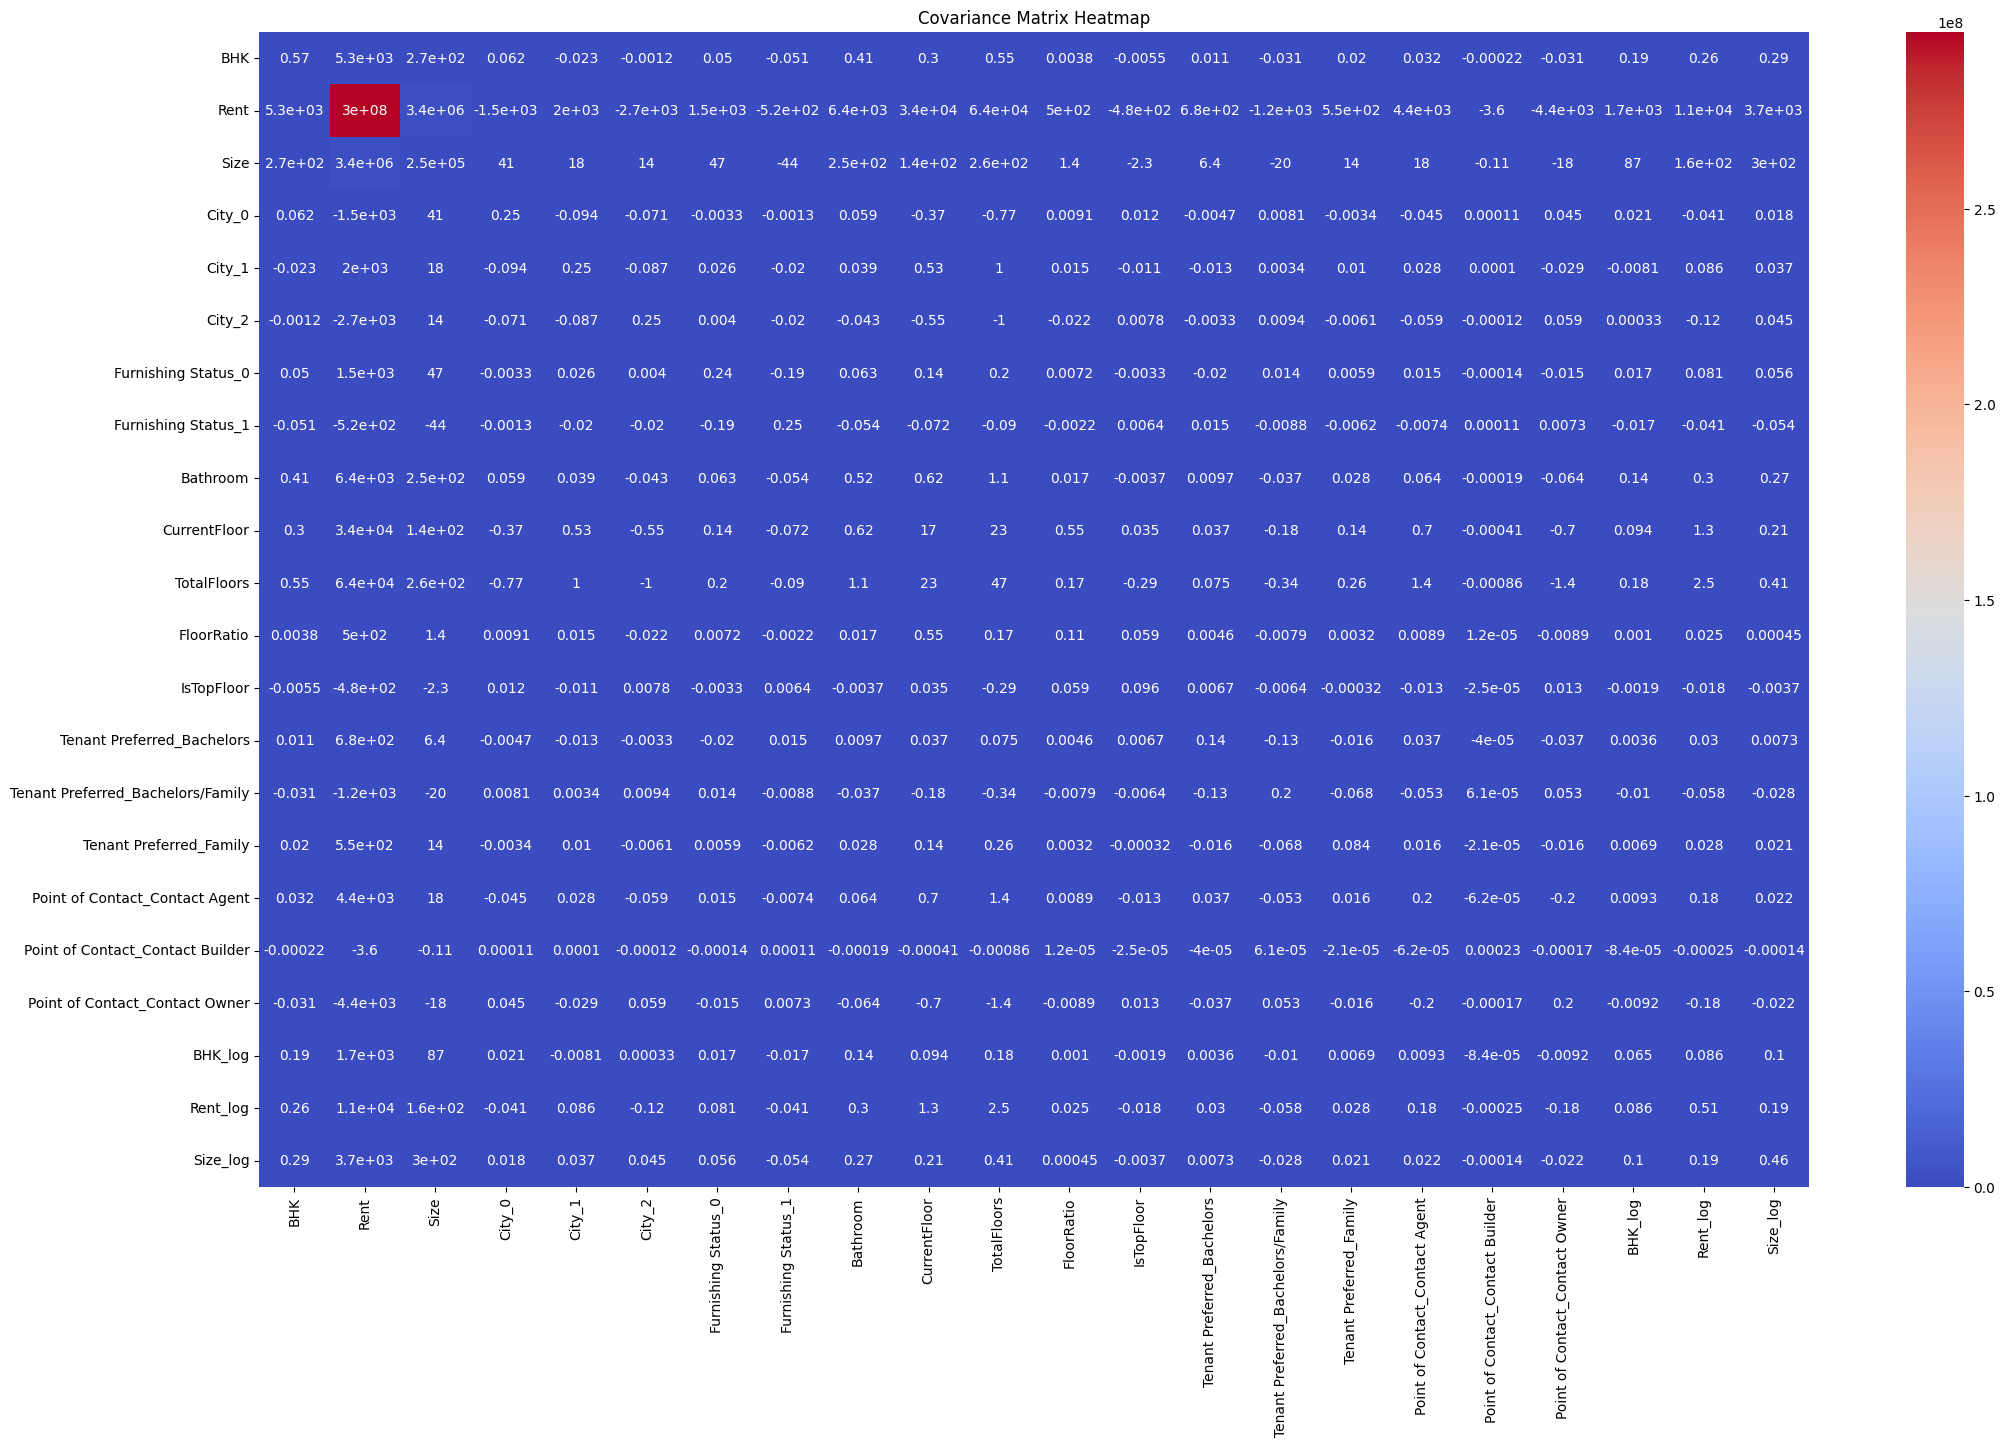

In [33]:
# Calculate Covariance
covariance_matrix = df[columns].cov()

# Visualize the Covariance Matrix using a Heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()


# Feature Selection & Engineering
1. **Correlation**
   * Steps to Take After Seeing the Correlation Matrix
     * Identify Highly Correlated Features: Look for pairs of features with a high correlation (close to 1 or -1). High correlation indicates multicollinearity, which can affect the stability of your model.
     * Check Correlation with Target Variable: Identify features that have a strong correlation with the target variable (Rent_log). These features are likely to be good predictors.
     
2. **Variance Inflation Factor (VIF)**     
3. **Mutual Information**
4. **Feature Importance**
5. **Lasso (L1 Regularization)**
6. **Recursive Feature Elimination (RFE)**
7. **R-squared and p-values**


In [34]:
df_temp = df.drop(columns=['Area Locality Labeled','BHK','Size'])

In [35]:
X = df_temp.drop(columns=['Rent', 'Rent_log'])
y = df['Rent_log']

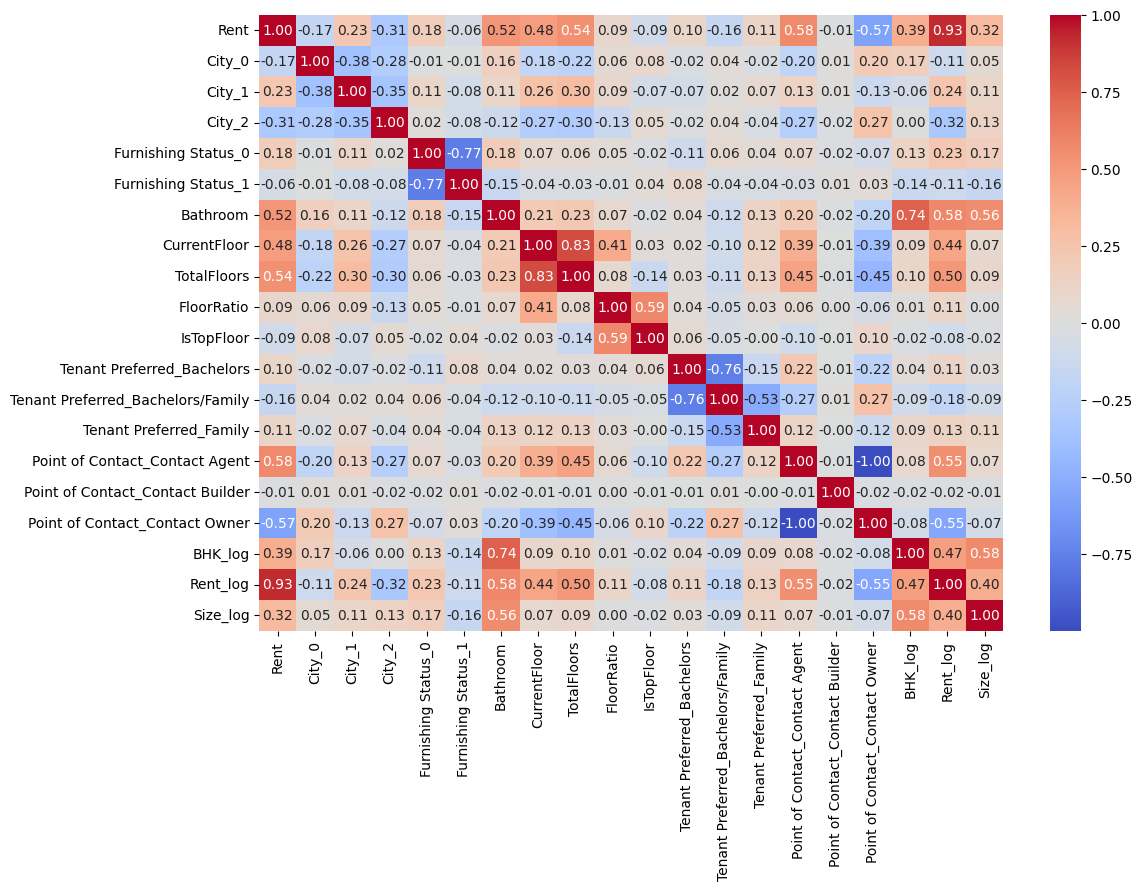

In [36]:
#Correlation Check for feature selection
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_temp.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


The Heat map shows the correlation of all features

In [37]:
# Threshold for removing correlated features
threshold = 0.8

# Find pairs of highly correlated features
corr_pairs = corr.unstack()
high_corr_pairs = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)]
print("Highly correlated pairs:\n", high_corr_pairs)

# Drop one of each pair of highly correlated features
features_to_drop = set()
for i in high_corr_pairs.index:
    features_to_drop.add(i[1])

print("Features to drop:", features_to_drop)
#X = df.drop(columns=list(features_to_drop) + ['Rent', 'Rent_log'])


Highly correlated pairs:
 Rent          Rent_log        0.925956
CurrentFloor  TotalFloors     0.825795
TotalFloors   CurrentFloor    0.825795
Rent_log      Rent            0.925956
dtype: float64
Features to drop: {'Rent_log', 'TotalFloors', 'Rent', 'CurrentFloor'}


In [38]:
X = df_temp.drop(columns=list(features_to_drop)+ ['Rent', 'Rent_log'])

Above code is to find Highly correlated features and which is removed to avoide unnecessary ro our model

# Checking VIF for Multicollinearity
Variance Inflation Factor (VIF) is a measure used to detect the severity of multicollinearity in regression analysis. Multicollinearity occurs when two or more independent variables in the model are highly correlated, which can inflate the standard errors of the coefficients and make the model unreliable.

**What to Check with VIF**
1. **VIF Values:**

   * VIF = 1: No correlation between the predictor and other predictors.
   * 1 < VIF < 5: Moderate correlation but usually not a cause for concern.
   * VIF > 5: High correlation that may warrant further investigation.
   * VIF > 10: Very high correlation indicating serious multicollinearity.


2. Features with High VIF:
   * Identify features with high VIF values (typically above 5 or 10) and consider removing or combining them to reduce multicollinearity.

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Drop features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > 10]['feature']
X = X.drop(columns=high_vif_features)
print("Remaining features after VIF check:", X.columns)


                              feature       VIF
0                              City_0  1.926658
1                              City_1  1.944032
2                              City_2  1.993352
3                 Furnishing Status_0  2.538634
4                 Furnishing Status_1  2.532759
5                            Bathroom  2.702606
6                          FloorRatio  1.628331
7                          IsTopFloor  1.619873
8          Tenant Preferred_Bachelors       inf
9   Tenant Preferred_Bachelors/Family       inf
10            Tenant Preferred_Family       inf
11     Point of Contact_Contact Agent       inf
12   Point of Contact_Contact Builder       inf
13     Point of Contact_Contact Owner       inf
14                            BHK_log  2.640007
15                           Size_log  1.786713
Remaining features after VIF check: Index(['City_0', 'City_1', 'City_2', 'Furnishing Status_0',
       'Furnishing Status_1', 'Bathroom', 'FloorRatio', 'IsTopFloor',
       'BHK_log', 

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Mutual Information
Mutual Information (MI) measures the dependency between two variables. A higher MI score indicates a stronger dependency between the feature and the target variable. Here’s how to interpret the bar graph generated from the MI scores

**Interpretation of Mutual Information Bar Graph**
1. **Identify Important Features**:

   * Features with higher MI scores are more informative about the target variable.
   * These features capture more of the target variable’s variability and are likely to be good predictors.
     
     
2. **Rank Features by Importance**:

   * The features are ranked by their MI scores from highest to lowest.
   * Features at the top of the bar graph are the most important, while those at the bottom are less important./
   
   
3. **Feature Selection**:

   * Focus on features with high MI scores.
   * Consider removing or combining features with low MI scores to reduce model complexity.


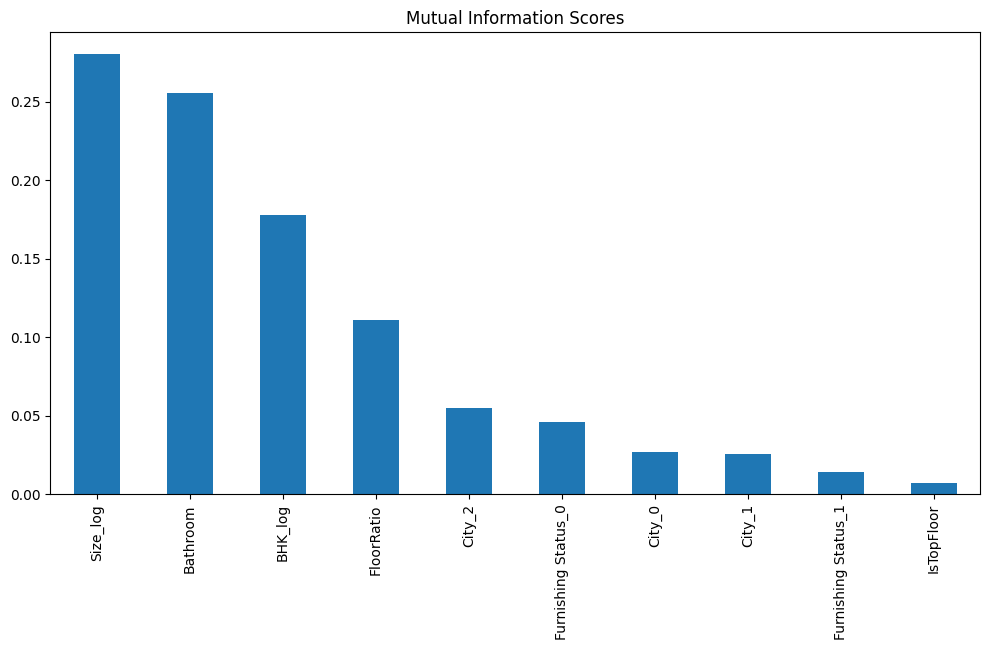

In [40]:
from sklearn.feature_selection import mutual_info_regression

X_numeric = X.select_dtypes(include=[np.number])
mi = mutual_info_regression(X_numeric, y)
mi_scores = pd.Series(mi, index=X_numeric.columns)
mi_scores.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Mutual Information Scores')
plt.show()


# Feature Importance
There are several ways to compute feature importance in machine learning, each providing different insights into how features contribute to the predictive power of the model. Here are some commonly used methods:

1. Model-Based Feature Importance
   * Random Forest Feature Importance
   * Gradient Boosting Feature Importance

2.  Linear Model Coefficients
    * Linear Regression
    * Lasso Regression
    * Mutual Information
    * Recursive Feature Elimination (RFE)
    * Correlation with the Target
    
    


**Feature Importance: Random Forest Feature Importance**

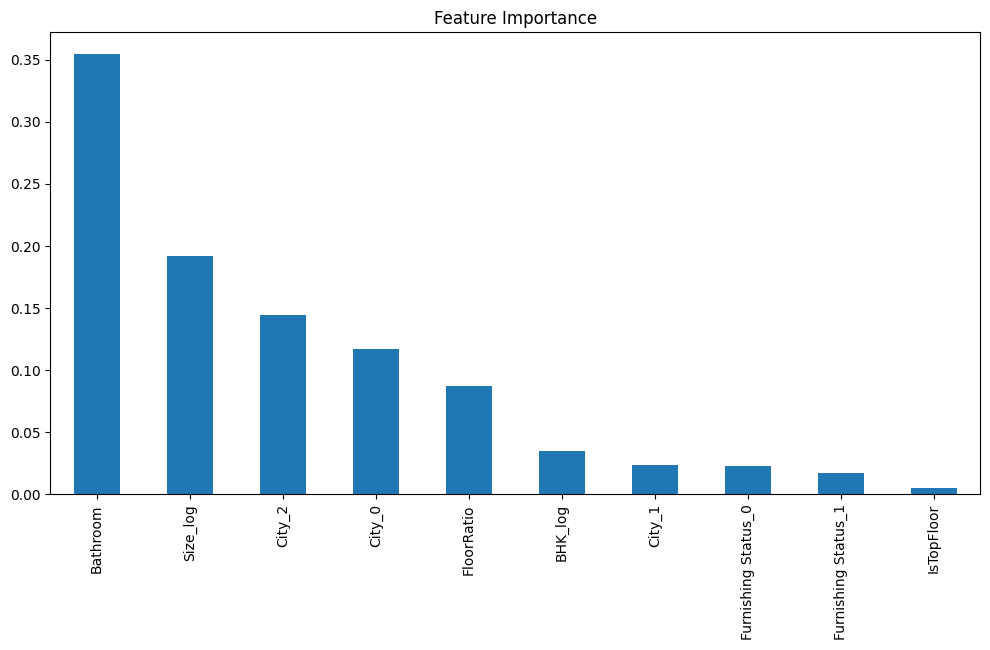

In [41]:
#Random Forest Feature Importance
from sklearn.ensemble import RandomForestRegressor

# Fit RandomForest model
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance')
plt.show()


**Feature Importance: Gradient Boosting Feature Importance**

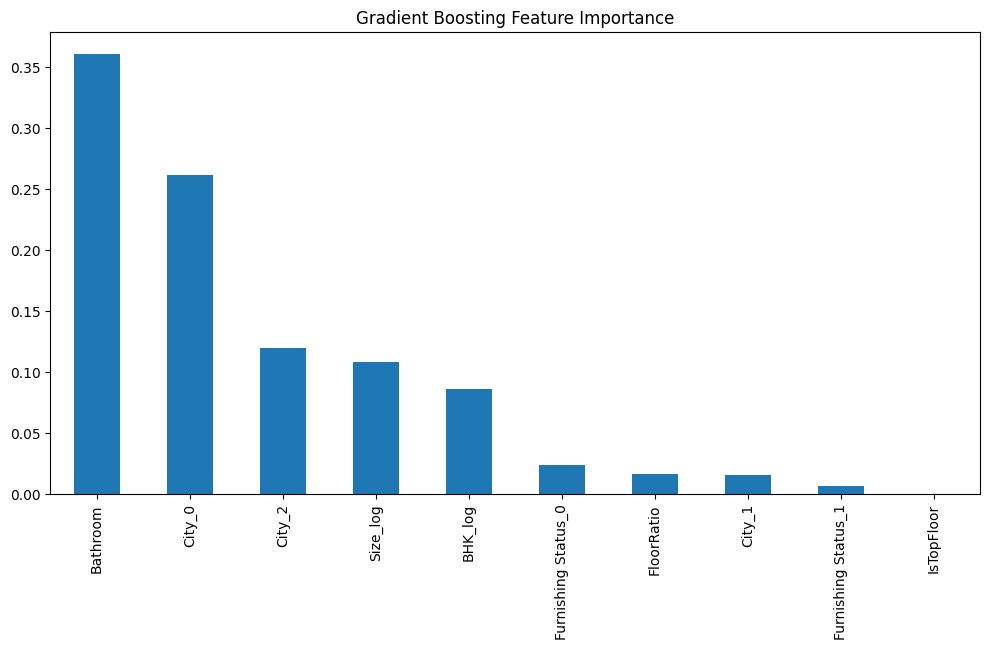

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X, y)

feature_importances = pd.Series(gb.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Gradient Boosting Feature Importance')
plt.show()


**Feature Importance: Linear Regression**


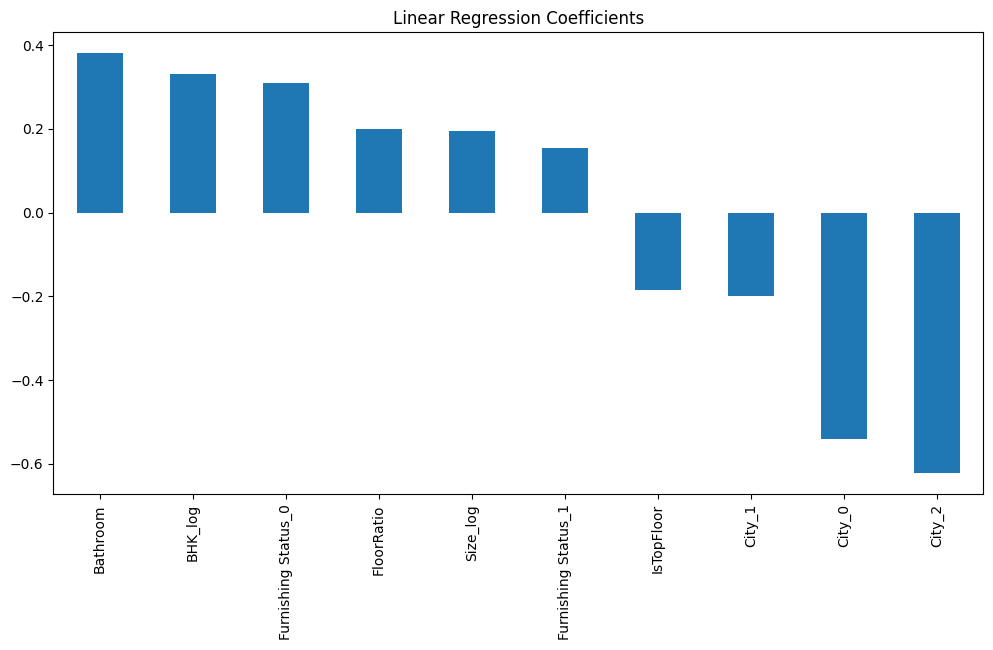

In [43]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

feature_importances = pd.Series(lr.coef_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Linear Regression Coefficients')
plt.show()


**Feature Importance: Lasso Regression**

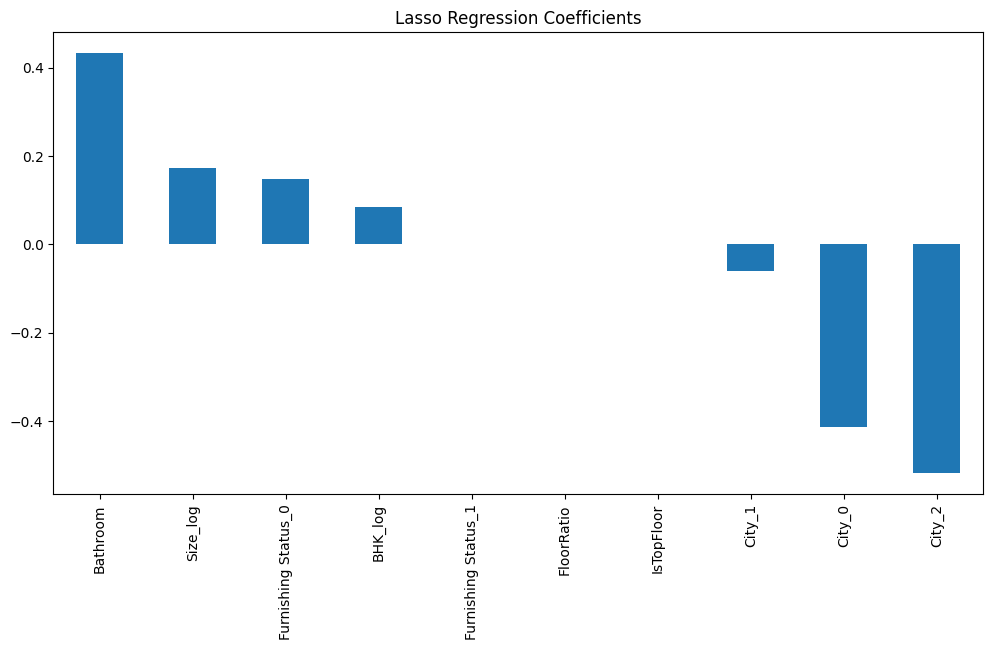

In [44]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

feature_importances = pd.Series(lasso.coef_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Lasso Regression Coefficients')
plt.show()


**Feature Importance: Permutation**

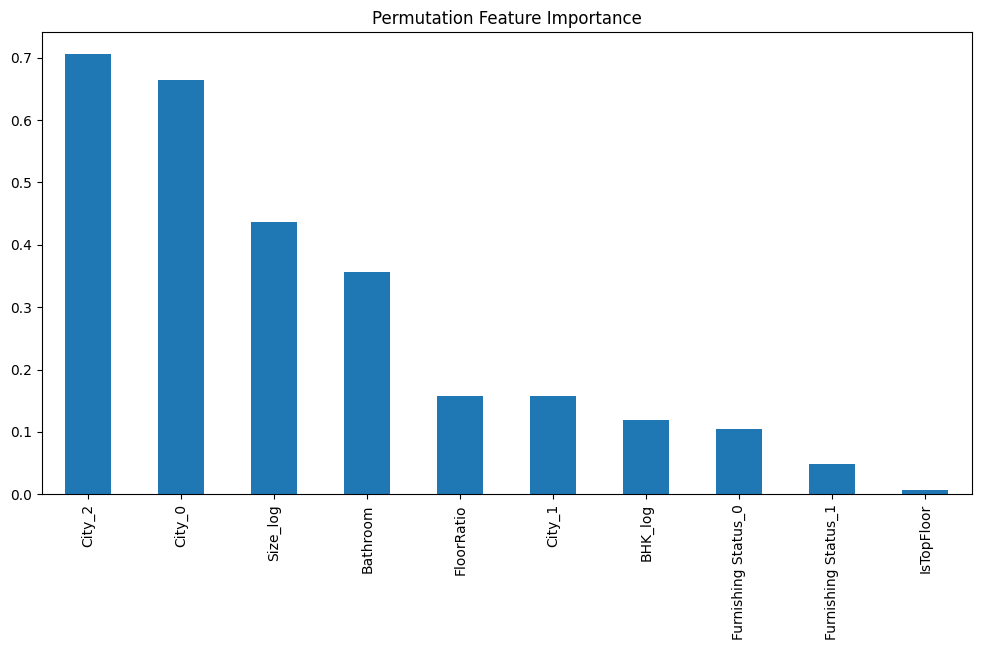

In [45]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X, y)
feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Permutation Feature Importance')
plt.show()


# Lets see the different method and its Feature Importance Points

In [46]:
y = df_temp['Rent_log']

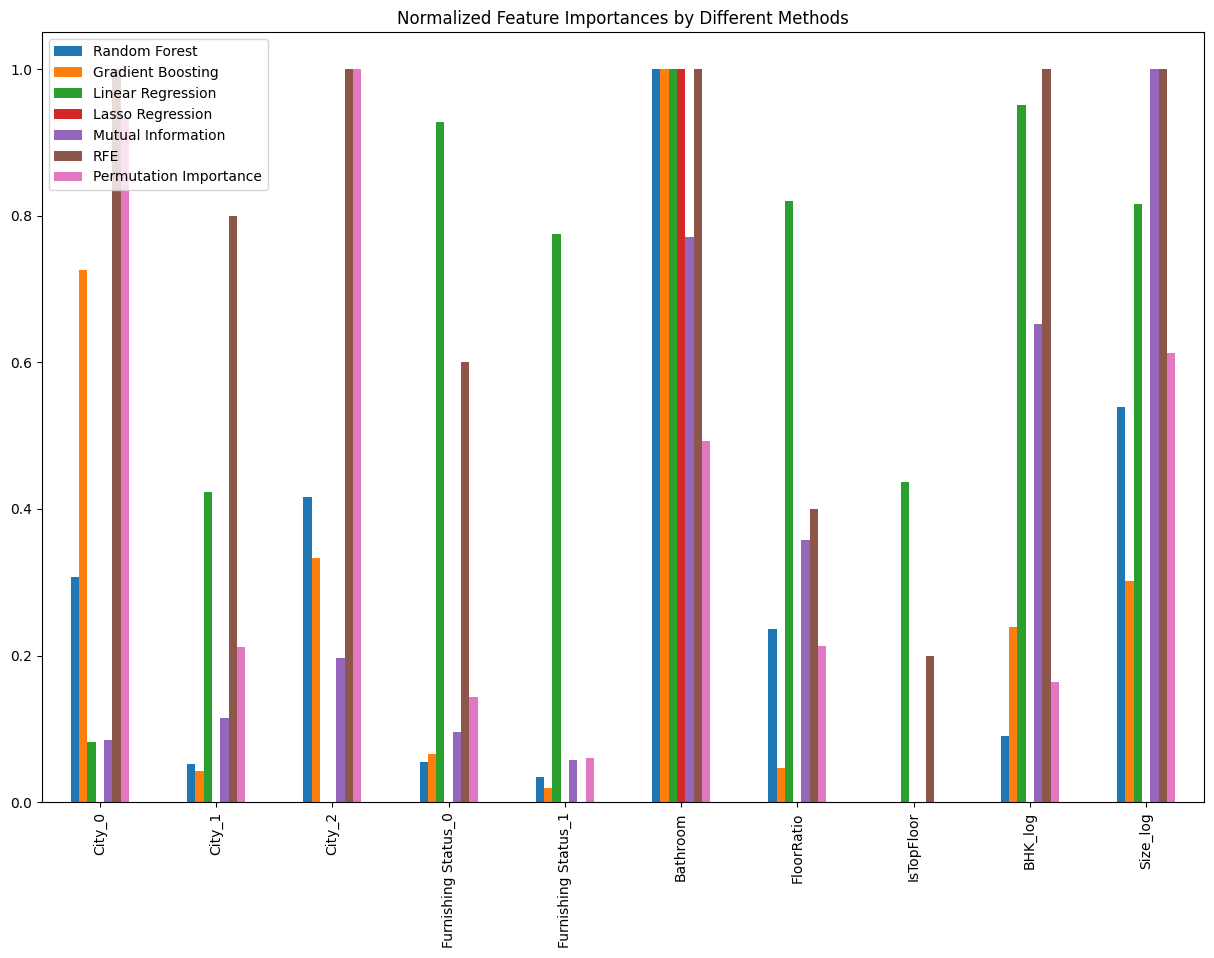

Rankings of features by different methods:
                      Random Forest  Gradient Boosting  Linear Regression  \
City_0                         4.0                2.0                9.0   
City_1                         8.0                8.0                8.0   
City_2                         3.0                3.0               10.0   
Furnishing Status_0            7.0                6.0                3.0   
Furnishing Status_1            9.0                9.0                6.0   
Bathroom                       1.0                1.0                1.0   
FloorRatio                     5.0                7.0                4.0   
IsTopFloor                    10.0               10.0                7.0   
BHK_log                        6.0                5.0                2.0   
Size_log                       2.0                4.0                5.0   

                     Lasso Regression  Mutual Information   RFE  \
City_0                            6.0               

In [47]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

# 1. Random Forest Feature Importance
rf = RandomForestRegressor()
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# 2. Gradient Boosting Feature Importance
gb = GradientBoostingRegressor()
gb.fit(X, y)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns)

# 3. Linear Regression Coefficients
lr = LinearRegression()
lr.fit(X, y)
lr_importances = pd.Series(lr.coef_, index=X.columns)

# 4. Lasso Regression Coefficients
lasso = LassoCV()
lasso.fit(X, y)
lasso_importances = pd.Series(lasso.coef_, index=X.columns)

# 5. Mutual Information
mi = mutual_info_regression(X, y)
mi_importances = pd.Series(mi, index=X.columns)

# 6. Recursive Feature Elimination (RFE)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X, y)
rfe_importances = pd.Series(rfe.ranking_, index=X.columns).map(lambda x: -x + 5)  # Invert ranking for comparison

# 7. Permutation Importance
perm_importance = permutation_importance(rf, X, y)
perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns)

# Normalize all importances for comparison
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

normalized_importances = pd.DataFrame({
    'Random Forest': normalize(rf_importances),
    'Gradient Boosting': normalize(gb_importances),
    'Linear Regression': normalize(lr_importances),
    'Lasso Regression': normalize(lasso_importances),
    'Mutual Information': normalize(mi_importances),
    'RFE': normalize(rfe_importances),
    'Permutation Importance': normalize(perm_importances)
})

# Plot normalized importances
normalized_importances.plot(kind='bar', figsize=(15, 10))
plt.title('Normalized Feature Importances by Different Methods')
plt.show()

# Compare rankings
importances_ranked = normalized_importances.rank(ascending=False)
print("Rankings of features by different methods:\n", importances_ranked)

# Summarize the rankings
rank_sum = importances_ranked.sum(axis=1).sort_values()
print("Sum of Rankings for each feature:\n", rank_sum)

# Select features consistently ranked high
selected_features = rank_sum[rank_sum < rank_sum.quantile(0.5)].index  # Select top 50% features
print("Selected features based on rankings:\n", selected_features)

# Evaluate model performance with selected features
X_selected = X[selected_features]
model = LinearRegression()
model.fit(X_selected, y)
score = model.score(X_selected, y)
print(f"Model performance with selected features (R^2): {score:.4f}")

# Check for Assumptions of Linear Regression
***Linearity*** : The relationship between the independent variables and the dependent variable should be linear.
  * **Check**: Plot scatter plots of each independent variable against the dependent variable (Rent) and look for a linear relationship.
  * **Corrective Actions**: If non-linear, consider transforming the variables (e.g., log transformation) or adding polynomial terms.

***Independence***:
  * Independence: Durbin-Watson statistic. A value around 2 indicates no autocorrelation.

***Homoscedasticity***:
  * Scatter plot of residuals vs. predicted values. Residuals should be randomly scattered around zero.
  
***Multicollinearity***:
  *  VIF values. High VIF (> 10) indicates multicollinearity.
  
***Normality***:
  * Q-Q plot and Shapiro-Wilk test. Points should lie on the line in the Q-Q plot, and a high p-value (> 0.05) in the Shapiro-Wilk test indicates normality.
  
By following these steps, you can check all the assumptions of linear regression and take necessary actions if any assumptions are violated.

In [48]:
X.columns

Index(['City_0', 'City_1', 'City_2', 'Furnishing Status_0',
       'Furnishing Status_1', 'Bathroom', 'FloorRatio', 'IsTopFloor',
       'BHK_log', 'Size_log'],
      dtype='object')

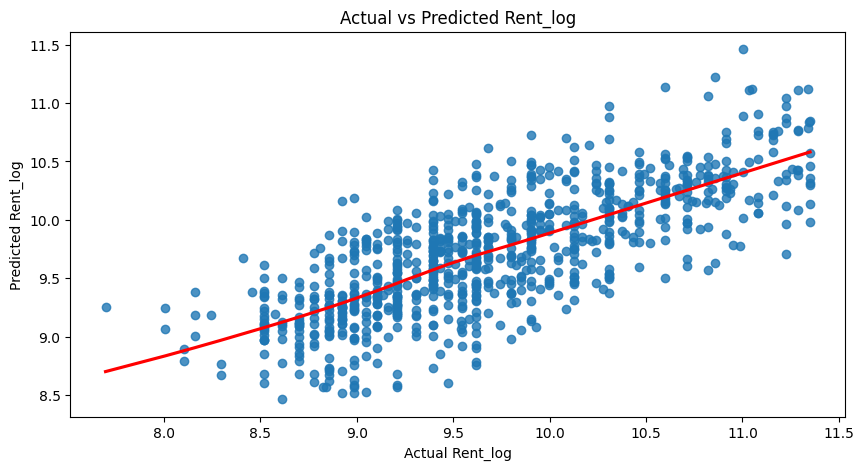

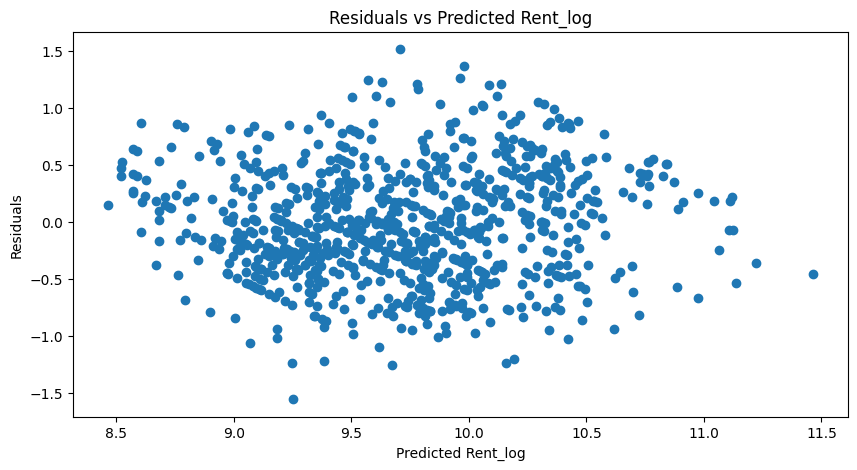

               feature        VIF
0               City_0   3.444759
1               City_1   4.086324
2               City_2   3.536688
3  Furnishing Status_0   6.081459
4  Furnishing Status_1   4.854194
5             Bathroom  17.642413
6           FloorRatio   4.591161
7           IsTopFloor   1.801610
8              BHK_log  47.922586
9             Size_log  61.554505


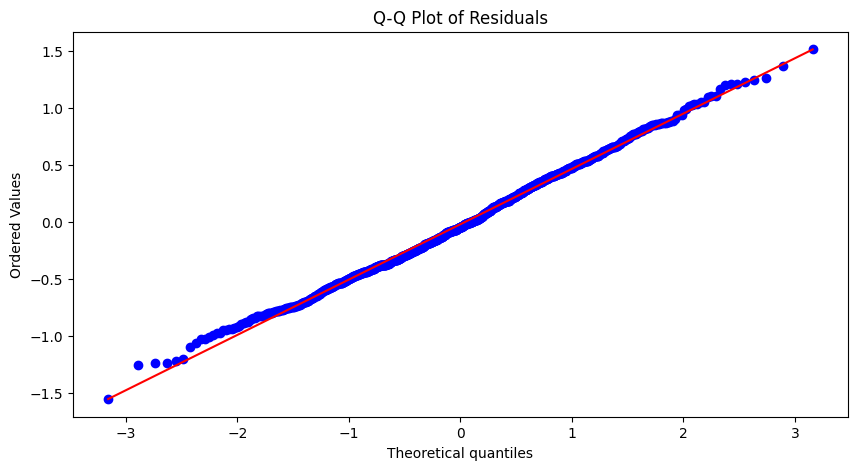

Statistics=0.9966750741004944, p-value=0.06338110566139221
Residuals look Gaussian (fail to reject H0)


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, probplot
import statsmodels.api as sm

# Define the target and features
#X = df.drop(columns=['Rent', 'Rent_log', 'Area Locality Labeled','BHK',])
#y = df['Rent_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Checking Linearity
plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=y_pred, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Actual Rent_log')
plt.ylabel('Predicted Rent_log')
plt.title('Actual vs Predicted Rent_log')
plt.show()

# Checking Homoscedasticity
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Rent_log')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Rent_log')
plt.show()

# Checking for Multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

# Checking Normality of Residuals
plt.figure(figsize=(10, 5))
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(residuals)
print(f'Statistics={stat}, p-value={p}')
if p > 0.05:
    print('Residuals look Gaussian (fail to reject H0)')
else:
    print('Residuals do not look Gaussian (reject H0)')


# Model Training Process
To train a multiple linear regression model, we need to follow these key steps:

1. **Split Data into Training and Testing Sets**:
   * The training set is used to train the model.
   * The testing set is used to evaluate the model's performance.
   
   
2. **Train the Multiple Linear Regression Model**:
   * Fit the model on the training data.
   * Evaluate the model on the testing data.

**Split Data into Training and Testing Sets**

**Purpose**: To ensure that the model can generalize to new, unseen data. The training set is used to build the model, and the testing set is used to evaluate its performance.

In [50]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined as the feature matrix and target vector respectively
X_selected = X[selected_features]

# Split the data: 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)



Training set shape: (3500, 10) (3500,)
Testing set shape: (876, 10) (876,)


**Train the Multiple Linear Regression Model**

**Purpose**: To learn the relationship between the features and

In [51]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)


#  Evaluate the Model
**Linear regression**

**Purpose**: To measure the model's performance and check how well it generalizes to new data.

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R^2)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.2358
R-squared: 0.5662


# Trying Lasso Regression for Feature Selection

In [53]:
from sklearn.linear_model import LassoCV

# Initialize and fit Lasso model
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test)

# Evaluate Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Mean Squared Error: {mse_lasso:.4f}")
print(f"Lasso R-squared: {r2_lasso:.4f}")

# Print Lasso coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
print("Lasso Coefficients:")
print(lasso_coefficients)


Lasso Mean Squared Error: 0.2356
Lasso R-squared: 0.5664
Lasso Coefficients:
City_0                -0.537696
City_1                -0.202121
City_2                -0.611285
Furnishing Status_0    0.298381
Furnishing Status_1    0.162936
Bathroom               0.366739
FloorRatio             0.210498
IsTopFloor            -0.194594
BHK_log                0.334388
Size_log               0.204599
dtype: float64


# Trying Polynomial Features


In [54]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Split the polynomial data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and fit the model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)

# Make predictions
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate Polynomial model
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Mean Squared Error: {mse_poly:.4f}")
print(f"Polynomial R-squared: {r2_poly:.4f}")


Polynomial Mean Squared Error: 0.1578
Polynomial R-squared: 0.7096


In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_gb = gb.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Mean Squared Error: {mse_gb:.4f}")
print(f"Gradient Boosting R-squared: {r2_gb:.4f}")



Gradient Boosting Mean Squared Error: 0.1516
Gradient Boosting R-squared: 0.7211


In [56]:
X.columns

Index(['City_0', 'City_1', 'City_2', 'Furnishing Status_0',
       'Furnishing Status_1', 'Bathroom', 'FloorRatio', 'IsTopFloor',
       'BHK_log', 'Size_log'],
      dtype='object')

# NOW MAKE USE OF NEW MODEL and PREDICT... IT's 72% accurate in prediction

In [57]:
import numpy as np
# Sample new data (ensure it matches the structure of your training data)
new_data = {
    'City_0': [0],
    'City_1': [1],
    'City_2': [0],
    'Furnishing Status_0': [0],
    'Furnishing Status_1': [1],
    'Bathroom': [4],
    'FloorRatio': [1/5],
    'IsTopFloor': [0],
    'BHK_log': [np.log1p(3)],
    'Size_log': [np.log1p(3000)]
}

# Convert the new data to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Use the trained Gradient Boosting model to predict the target variable for the new data
log_transformed_prediction = gb.predict(new_data_df)[0]

# Convert the log-transformed prediction back to the original scale
original_prediction = np.expm1(log_transformed_prediction)

print(f"Predicted Rent for the new data: {original_prediction:.2f}")

Predicted Rent for the new data: 112400.65
